# An idea on how to bring several feature selection methods together

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## read csv

In [2]:
df = pd.read_csv('cup98_modeling_data_sample.csv')

In [3]:
df.head(3)

,Unnamed: 0,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,...,pvstate,inhouse,p3donor,sweeps,homeowner,cluster1_low_01,cluster1_low_02,cluster1_low_03,cluster1_low_04,cluster1_low_05
0,88033,82.0,1.527576,5.0,7.000000,11,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,16384,57.0,1.527576,4.0,2.000000,5,0.0,0.0,2.0,0.0,...,0,0,0,0,1,1,0,0,0,0
2,43512,44.0,1.000000,4.0,5.345675,0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1


In [4]:
df.shape

(28606, 425)

## Check for imbalance

<Axes: xlabel='index', ylabel='proportion'>

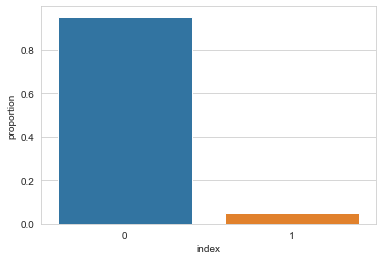

In [5]:
#check for imbalance

k=(df['TARGET_B']
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
)
sns.barplot(data=k, x='index', y='proportion')

In [7]:
!pip install xgboost

     |████████████████████████████████| 1.8 MB 1.1 MB/s eta 0:00:01


In [8]:
##Read in a few packages to use

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif, RFECV, RFE, SelectFromModel
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

##  Feature selection

In [9]:
### create X and Y and then drop highly correlated vars

X = df.drop(['CONTROLN', 'TARGET_B'], axis=1)
y= df['TARGET_B'].rename('target')

# we want to drop all very highly correlated features from X

correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
X.drop(correlated_features, axis=1, inplace=True)        

X.shape

(28606, 337)

In [10]:
##Split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape

(20024, 337)

# Correlation Method to select features with high correlation with the target feature

In [11]:
# no of maximum features we need to select
num_feats=50


col=['target']
y2 = pd.DataFrame(y_train, columns=col)


feature_name = list(X_train.columns)



def cor_selector(X_train, y2,num_feats):
    cor_list = []
    feature_name = X_train.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X_train.columns.tolist():
        cor = np.corrcoef(X_train[i], y2.target)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X_train.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_train, y2,num_feats)

print(str(len(cor_feature)), 'selected features')

50 selected features


### Using Chi sq selector

In [12]:
X_norm = MinMaxScaler().fit_transform(X_train)

chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

50 selected features


### Mutual Infor Classification
https://en.wikipedia.org/wiki/Mutual_information

In [13]:

mi_selector = SelectKBest(mutual_info_classif, k=num_feats)
mi_selector.fit(X_norm, y_train)
mi_support = mi_selector.get_support()
mi_feature = X_train.loc[:,mi_support].columns.tolist()
print(str(len(mi_feature)), 'selected features')

50 selected features


### Recursive Feature Elimination

https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15

In [14]:
##Logit Estimator 

rfe_selector = RFE(estimator=LogisticRegression(solver='liblinear'),n_features_to_select=num_feats, step=10, verbose=0)
rfe_selector.fit(X_norm, y_train)


rfe_logit_support = rfe_selector.get_support()
rfe_logit_feature = X_train.loc[:,rfe_logit_support].columns.tolist()
print(str(len(rfe_logit_feature)), 'selected features')


50 selected features


In [15]:
## Estimator on xgboost

rfe_selector = RFE(estimator=XGBClassifier(eval_metric='logloss', n_estimators=10), n_features_to_select=num_feats, step=10, verbose=0)
rfe_selector.fit(X_norm, y_train)

rfe_xgb_support = rfe_selector.get_support()
rfe_xgb_feature = X_train.loc[:,rfe_xgb_support].columns.tolist()
print(str(len(rfe_xgb_feature)), 'selected features')

50 selected features


### Using SelectFromModel

In [17]:
##logistic

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

50 selected features


In [18]:
## Random Forest
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=10), max_features=num_feats)
embeded_rf_selector.fit(X_norm, y_train)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

50 selected features


In [20]:
## Light GBM Classifier

from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=10, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X_norm, y_train)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

OSError: dlopen(/Users/mac/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: '/usr/local/opt/libomp/lib/libomp.dylib'
  Referenced from: '/Users/mac/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so'
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

## Putting it all together

In [24]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name,
                                     'Pearson':cor_support,
                                     'Chi2':chi_support,
                                     'Mi':mi_support,
                                     'RFE Logit': rfe_logit_support,
                                     'RFE XGB': rfe_xgb_support,                                                                      
                                     'Embeded Logistic':embeded_lr_support,
                                     'Embeded Random Forest':embeded_rf_support, 
                                     'Embeded LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top features
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(10)



NameError: name 'embeded_lgb_support' is not defined

In [ ]:
###create csv of features for future use in modeling

feature_selection_df.to_csv('selected_features1.csv', index=False)

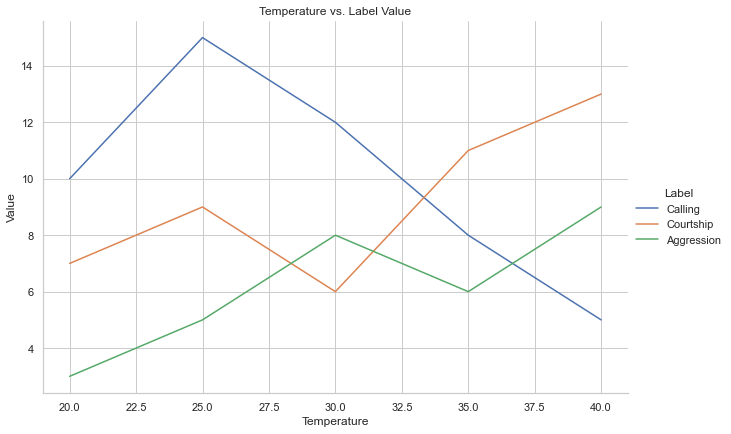

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    'Temperature': [20, 25, 30, 35, 40],
    'Calling': [10, 15, 12, 8, 5],
    'Courtship': [7, 9, 6, 11, 13],
    'Aggression': [3, 5, 8, 6, 9]
}
df = pd.DataFrame(data)

# Reshape the data into long format
df_long = df.melt('Temperature', var_name='Label', value_name='Value')

# Create a panel graph
sns.set(style='whitegrid')
sns.relplot(
    data=df_long,
    x='Temperature',
    y='Value',
    hue='Label',
    kind='line',
    height=6,
    aspect=1.5
)

# Set the plot title and labels
plt.title('Temperature vs. Label Value')
plt.xlabel('Temperature')
plt.ylabel('Value')

# Display the plot
plt.show()

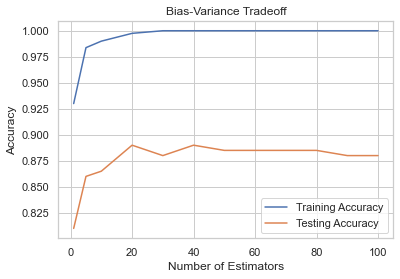

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate a synthetic classification dataset
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of n_estimators (number of trees) values
n_estimators_values = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialize lists to store training and testing accuracies
train_accuracies = []
test_accuracies = []

# Train Random Forest Classifier with different n_estimators values
for n_estimators in n_estimators_values:
    # Create Random Forest Classifier with the given n_estimators value
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Fit the model on the training data
    rf.fit(X_train, y_train)
    
    # Make predictions on the training and testing data
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # Calculate and store the training and testing accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the bias-variance tradeoff
plt.plot(n_estimators_values, train_accuracies, label='Training Accuracy')
plt.plot(n_estimators_values, test_accuracies, label='Testing Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()
